# Assignment 2: Classify Images of Colon Cancer
### Group 39: 
- Ly Ngoc Gia Bao (s3634975)
- Hoang Vu Nguyen (s4020628)

Date: 18.05.2025

Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used:
* pandas
* re
* numpy
* os
* itertools
* nltk

## 1. Introduction


In [3]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from PIL import Image
import cv2
from collections import Counter
from skimage import io, color, exposure
import random
from collections import defaultdict
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split


random.seed(42)

## 2. Development strategy


## 3. Splitting the dataset

In this section, the given dataset will be split into a train and a test set with a proportion of 80:20. All the data analysis and training process, including data pre-processing, baseline model training, and hyperparameter tuning, will be performed on the training set. The test set is used for the final evaluation. Moreover, as working with medical data, the dataset will be divided based on the **patient** level to: 
- Prevent the data leakage, when the instance appears in both the train and test sets, resulting in the model learn on the data it is trained on
- Mimic the scenario of diagnosing the new patient via a generalizing model
- Avoid patient correlations that result in a skewed evaluation.

In [4]:
# Load the data set
dataset_path = './data/data_labels_mainData.csv'
data = pd.read_csv(dataset_path)
print(f"The dataset has: {data.shape[0]} rows and {data.shape[1]} columns")

The dataset has: 9896 rows and 6 columns


In [5]:
def plot_categorical_distribution(data):
    # Prepare data
    cell_type_counts = data[['cellType', 'cellTypeName']].value_counts().reset_index()
    cell_type_counts.columns = ['cellType', 'cellTypeName', 'Count']
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    
    # Plot 1: Cancerous vs Non-Cancerous
    sns.countplot(x='isCancerous', data=data, ax=axes[0])
    axes[0].set_title('Cancerous vs Non-Cancerous')
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(['Non-Cancerous', 'Cancerous'])
    
    # Plot 2: Cell Type Distribution
    sns.barplot(data=cell_type_counts, x="cellTypeName", y="Count", ax=axes[1])
    axes[1].set_title('Cell Type Distribution')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

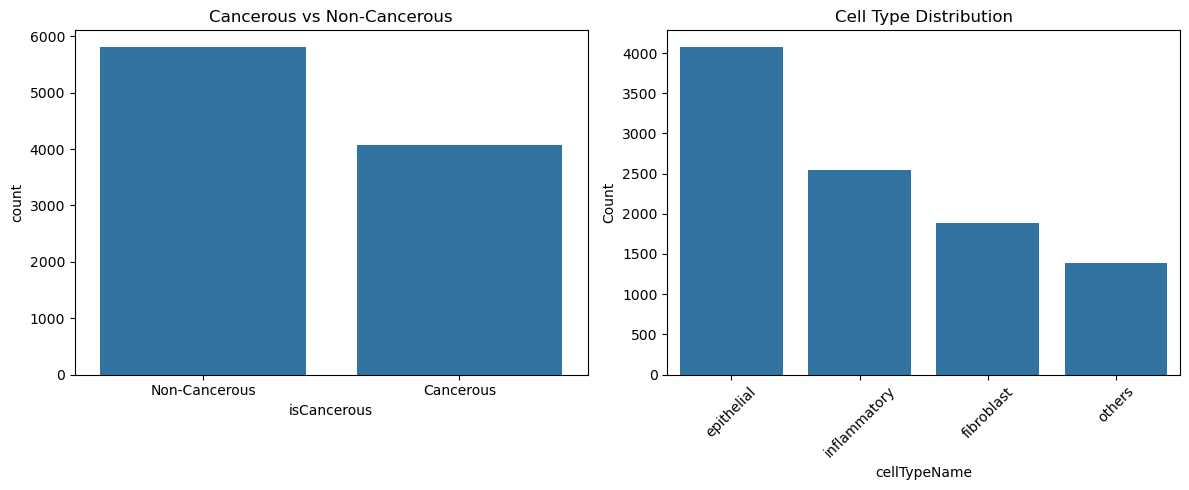

In [6]:
plot_categorical_distribution(data)

The generated graphs depict the the distribution of the two categorical variables: **isCanerous** and **cellType**. From the graph, the distribution is not distributed evenly. Therefore, when splitting the data to train and test sets, both sets should have the classes to train or test. Also, the miniroty should have enough data to train 

In [7]:
# Create a combined label per patient for stratification (if patients have varying labels)
patient_data = data.groupby('patientID').agg({
    'cellType': lambda x: x.mode()[0],  # Or a more robust method if needed
    'isCancerous': lambda x: x.mode()[0]
}).reset_index()

# Create stratification target per patient
patient_data['combined_target'] = patient_data['cellType'].astype(str) + '_' + patient_data['isCancerous'].astype(str)

# Split patient IDs
train_patients, test_patients = train_test_split(
    patient_data['patientID'],
    test_size=0.20,
    random_state=0,
    stratify=patient_data['combined_target']
)

# Filter the main data by patient ID
train_data = data[data['patientID'].isin(train_patients)]
test_data = data[data['patientID'].isin(test_patients)]

# Define targets
y_train = train_data['cellType'].astype(str) + '_' + train_data['isCancerous'].astype(str)
y_test = test_data['cellType'].astype(str) + '_' + test_data['isCancerous'].astype(str)

In [8]:
print(f"The train dataset now has: {train_data.shape[0]} rows and {train_data.shape[1]} columns")

The train dataset now has: 7768 rows and 6 columns


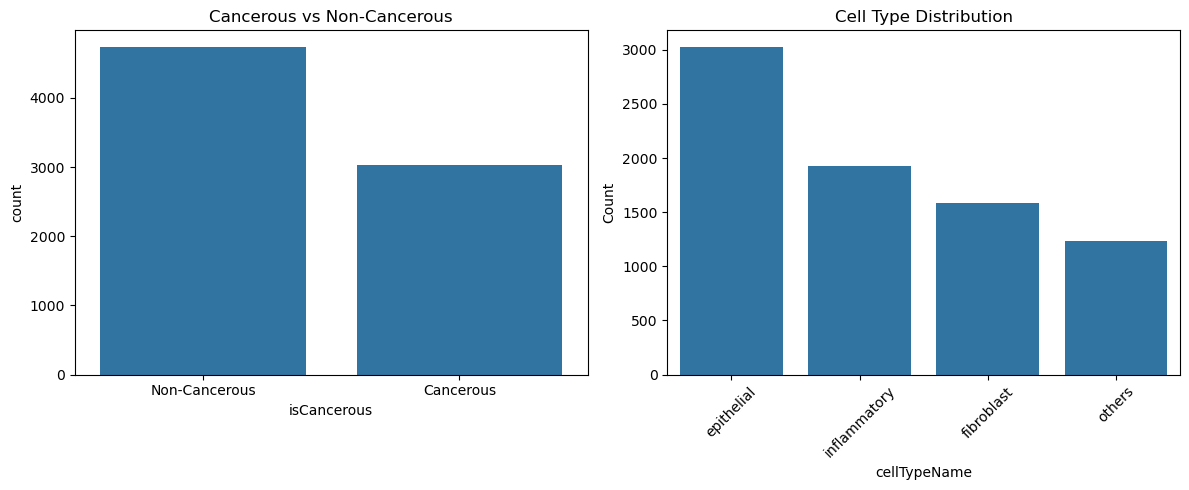

In [9]:
plot_categorical_distribution(train_data)

From the generated figures, the train set contains enough data to train as the minority classes has more than 1000 samples. Also, the distribution of the classes remains.

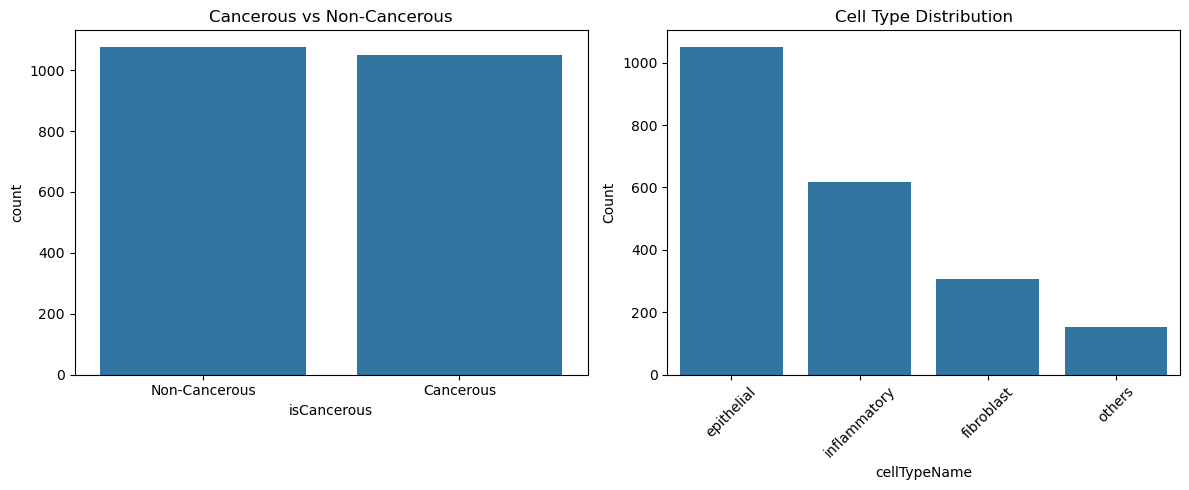

In [10]:
plot_categorical_distribution(test_data)

From the generated figures, the test set contains enough data to train as the minority classes has more than 1000 samples. Also, the distribution of the classes remains.

**Data leakage check**: As mentioned earlier, the train and test set should not contain the sample of same patient ID. So, the following code is used to validate the approach

In [11]:
# This code is used to do the final check to ensure that there is no instances that appear in both train and set set
patient_train_data = train_data['patientID'].unique()
patient_test_data = test_data['patientID'].unique()

res = list(set(patient_train_data) & set(patient_test_data))
if len(res) == 0:
    print("In both train and test sets, there is no record with same ID")
else:
    print("WARN: The dataset has leakage issue")

In both train and test sets, there is no record with same ID


In [12]:
train_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
19,19035,2,19035.png,fibroblast,0,0
20,19036,2,19036.png,fibroblast,0,0
21,19037,2,19037.png,fibroblast,0,0
22,19038,2,19038.png,fibroblast,0,0
23,19039,2,19039.png,fibroblast,0,0


In [13]:
# export to csv
train_data.to_csv('./data/train.csv', index=False)
test_data.to_csv('./data/test.csv', index=False)

In [14]:
# export to csv
is_cancerous_train = train_data.copy()
is_cancerous_train.drop(['cellTypeName', 'cellType'], axis=1, inplace=True)
is_cancerous_test = test_data.copy()
is_cancerous_test.drop(['cellTypeName', 'cellType'], axis=1, inplace=True)

is_cancerous_train.to_csv('./data/is_cancerous_train.csv', index=False)
is_cancerous_test.to_csv('./data/is_cancerous_test.csv', index=False)

In [15]:
cell_type_train = train_data.copy()
cell_type_train.drop(['isCancerous'], axis=1, inplace=True)
cell_type_test = test_data.copy()
cell_type_test.drop(['cellTypeName'], axis=1, inplace=True)

cell_type_train.to_csv('./data/cell_type_train.csv', index=False)
cell_type_test.to_csv('./data/cell_type_test.csv', index=False)

In [16]:
# delete variables for saving memory
del train_data, test_data, is_cancerous_train, is_cancerous_test, cell_type_train, cell_type_test, data

## 4. Exploratory data analysis
This section aims to perform the exploratory data analysis (EDA) on the dataset. The EDA consists of two main parts, including:

### Basic information

In [17]:
# Load the data set
dataset_path = './data/train.csv'
data = pd.read_csv(dataset_path)

In [18]:
print("Dataset Overview:")
print(f"Dataset shape: {data.shape}")
print("\nFirst few rows:")
print(data.head())

Dataset Overview:
Dataset shape: (7768, 6)

First few rows:
   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       19035          2  19035.png   fibroblast         0            0
1       19036          2  19036.png   fibroblast         0            0
2       19037          2  19037.png   fibroblast         0            0
3       19038          2  19038.png   fibroblast         0            0
4       19039          2  19039.png   fibroblast         0            0


In [19]:
# 2. Basic Data Information
print("\n--- Data Information ---")
print(data.info())


--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7768 entries, 0 to 7767
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    7768 non-null   int64 
 1   patientID     7768 non-null   int64 
 2   ImageName     7768 non-null   object
 3   cellTypeName  7768 non-null   object
 4   cellType      7768 non-null   int64 
 5   isCancerous   7768 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 364.2+ KB
None


In [20]:
print("\n--- Missing Values ---")
print(data.isnull().sum())


--- Missing Values ---
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


The data_labels_mainData.csv dataset has 9896 rows and 6 columns, in which there are two ID columns including the InstanceID and patientID. The two columns **cellType** and **isCancerous** are two target variables. The cellTypeName is the text version of the **cellType** column. For the independent columns, ImageName the path to the image located under **patches_images** folder. The dataset does not have any missing value.

### Explore the categorical variables

#### isCancerous variable

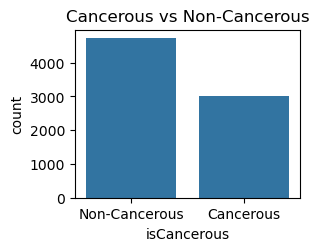

In [21]:
# 4.2 Cancerous Distribution
plt.subplot(2, 2, 2)
sns.countplot(x='isCancerous', data=data)
plt.title('Cancerous vs Non-Cancerous')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.show()

In [36]:
is_cancerous_counts = data[['isCancerous']].value_counts().reset_index()
is_cancerous_counts.columns = ['isCancerous', 'Count']
is_cancerous_counts

,isCancerous,Count
0,0,4740
1,1,3028


The distribution of the isCancerous variable is imbalanced, as the number of **Cancerous** sample is less than 36.12% comparing to the **Non-Cancerous**.

#### Cell Type

In [22]:
cell_type_counts = data[['cellType', 'cellTypeName']].value_counts().reset_index()
cell_type_counts.columns = ['cellType', 'cellTypeName', 'Count']
cell_type_counts

,cellType,cellTypeName,Count
0,2,epithelial,3028
1,1,inflammatory,1925
2,0,fibroblast,1581
3,3,others,1234


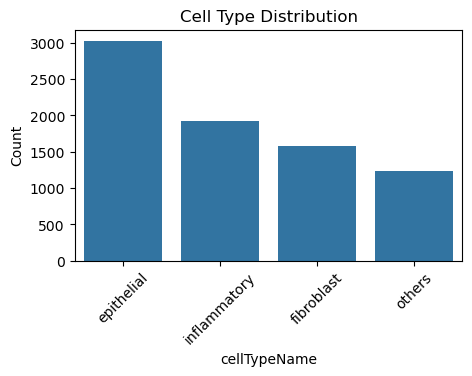

In [23]:
plt.figure(figsize=(5, 3))
sns.barplot(cell_type_counts, x="cellTypeName", y="Count")
plt.title('Cell Type Distribution')
plt.xticks(rotation=45)
plt.show()

For the cell type varible, the cell type is already encoded, which is shown in the following table. 

| Cell type name | Encoded value |
| - | - |
| fibroblast | 0 |
| inflammatory | 1 |
| epithelial | 2 |
| others | 3 |


Also, the distribution of the cell type shows that the classes are imbalanced. For example, the **epithelial** class has 4079 instances, which is nearly twice (~2.16) as many as the fibroblast class.

### Patient distribution

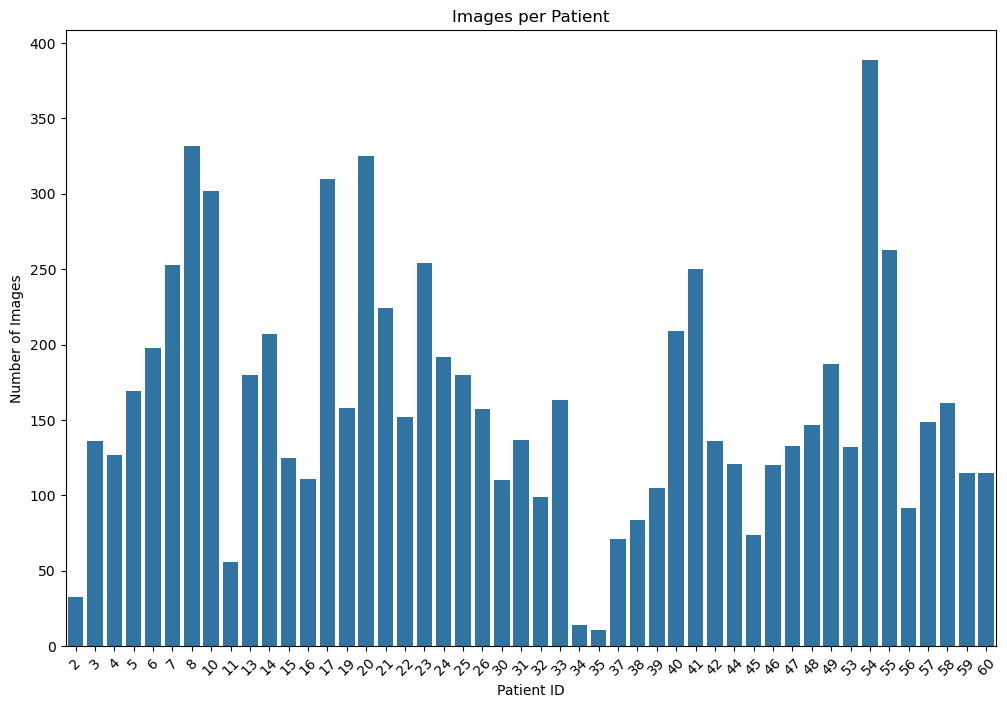

In [24]:
patient_counts = data['patientID'].value_counts()
plt.figure(figsize=(12, 8))

sns.barplot(x=patient_counts.index, y=patient_counts.values)

plt.title('Images per Patient')
plt.xlabel('Patient ID')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [25]:
sorted_counts = patient_counts.sort_values(ascending=False)
sorted_counts.head(10)

patientID
54    389
8     332
20    325
17    310
10    302
55    263
23    254
7     253
41    250
21    224
Name: count, dtype: int64

In [26]:
sorted_counts.tail(10)

patientID
39    105
32     99
56     92
38     84
45     74
37     71
11     56
2      33
34     14
35     11
Name: count, dtype: int64

From the given chart, the provided images for each patient is not distributed evenly. For example, the patient **54** has 389 instances, wherease, there are only **11** instances for patient 35.

### Cell type and Cancerous Status

This section aims to examine the relationsip between two categorical varibales (isCanerous and cellType) to answer the question in which cell type is detected, the patient will have cancer?

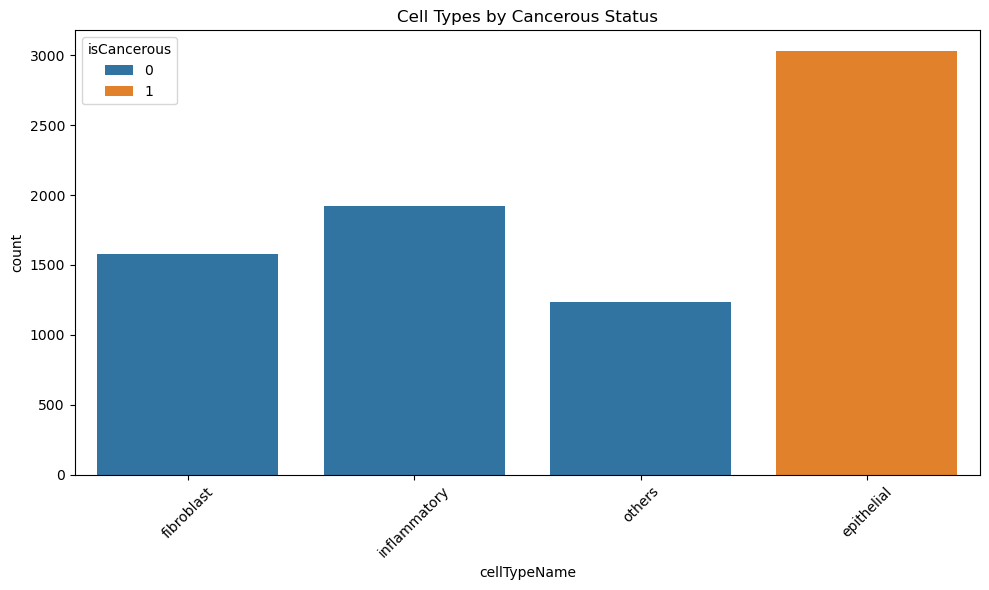

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(x='cellTypeName', hue='isCancerous', data=data)
plt.title('Cell Types by Cancerous Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the given chart, it is noticeable that when the epithelial cell type is detected, the patient is diagonised as having cancer.

### Image analysis

The image is analyzed with three main aspects, including: **aspect ratio**, **size**, **color chanel**

**Image sizes**

Text(0.5, 1.0, 'Distribution of Image Dimensions')

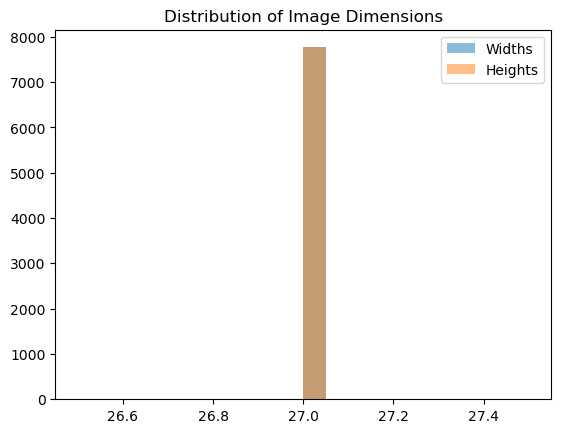

In [28]:
# TODO: add the code for the image analysis here. Check for the size, noise and resolution
from collections import Counter
sizes = [Image.open(f"./data/patch_images/{img}").size for img in data['ImageName'].values]
widths, heights = zip(*sizes)
plt.hist(widths, bins=20, alpha=0.5, label='Widths')
plt.hist(heights, bins=20, alpha=0.5, label='Heights')
plt.legend()
plt.title("Distribution of Image Dimensions")

In [29]:

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def analyze_images_by_cell_type(data, image_dir, cell_type_name):
    
    # Check if directory exists
    if not os.path.exists(image_dir):
        print(f"Image directory {image_dir} not found. Skipping analysis.")
        return
    
    # Create dictionaries to store sample images and their analyses
    sample_images = {}
    image_analyses = defaultdict(dict)
    
    # Get all images of this cell type
    cell_type_images = data[data['cellTypeName'] == cell_type_name]['ImageName'].tolist()
    
    if not cell_type_images:
        print(f"No images found for cell type {cell_type} ({cell_type_name})")
        return    
    # Randomly select one image
    selected_img_name = random.choice(cell_type_images)
    image_path = os.path.join(image_dir, selected_img_name)
    
    try:
        # Try to read the image
        img = cv2.imread(image_path)
        
        if img is None:
            print(f"Could not read image: {image_path}")
            return
            
        # Store the image and its details
        sample_images[cell_type_name] = {
            'name': selected_img_name,
            'image': img,
            'cell_type_name': cell_type_name
        }
        
        # Perform analysis
        image_analyses[cell_type_name] = analyze_single_image(img, selected_img_name, cell_type_name)
        
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
    
    # Create visualizations
    if sample_images:
        # Create a comprehensive figure with subplots
        visualize_image_analyses(sample_images, image_analyses)
    else:
        print("No images could be processed for analysis.")

def analyze_single_image(img, img_name, cell_type_name):
    # Convert BGR to RGB for analysis
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to HSV and LAB color spaces for additional analysis
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Basic image properties
    height, width, channels = img.shape
    
    # Intensity analysis
    channel_names = ['Red', 'Green', 'Blue']
    channel_stats = {}
    
    for i, channel_name in enumerate(channel_names):
        channel = img_rgb[:,:,i]
        channel_stats[channel_name] = {
            'mean': np.mean(channel),
            'std': np.std(channel),
            'min': np.min(channel),
            'max': np.max(channel),
            'median': np.median(channel),
            'histogram': np.histogram(channel, bins=256, range=(0,256))[0]
        }
    
    # Grayscale intensity
    gray_stats = {
        'mean': np.mean(img_gray),
        'std': np.std(img_gray),
        'min': np.min(img_gray),
        'max': np.max(img_gray),
        'median': np.median(img_gray),
        'histogram': np.histogram(img_gray, bins=256, range=(0,256))[0]
    }
    
    # HSV analysis
    hsv_names = ['Hue', 'Saturation', 'Value']
    hsv_stats = {}
    
    for i, hsv_name in enumerate(hsv_names):
        channel = img_hsv[:,:,i]
        hsv_stats[hsv_name] = {
            'mean': np.mean(channel),
            'std': np.std(channel),
            'min': np.min(channel),
            'max': np.max(channel),
            'median': np.median(channel),
            'histogram': np.histogram(channel, bins=256, range=(0,256))[0]
        }
    
    # Calculate texture features using GLCM or other methods if needed
    # (Code for texture analysis would go here)
    
    # Calculate basic edge statistics
    edges = cv2.Canny(img_gray, 100, 200)
    edge_percentage = np.sum(edges > 0) / (height * width) * 100
    
    return {
        'filename': img_name,
        'cell_type': cell_type_name,
        'dimensions': {'height': height, 'width': width, 'channels': channels},
        'size_bytes': img.nbytes,
        'rgb_stats': channel_stats,
        'gray_stats': gray_stats,
        'hsv_stats': hsv_stats,
        'edge_percentage': edge_percentage
    }

def visualize_image_analyses(sample_images, image_analyses):
    n_cell_types = len(sample_images)
    
    for cell_type, img_data in sample_images.items():
        analysis = image_analyses[cell_type]
        img = img_data['image']
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cell_type_name = img_data['cell_type_name']
        img_name = img_data['name']
        
        # Create a large figure with multiple subplots
        fig = plt.figure(figsize=(20, 16))
        gs = gridspec.GridSpec(4, 4)
        
        # Title with image and cell information
        plt.suptitle(f"Analysis of {img_name} - {cell_type_name} (Cell Type {cell_type})", 
                     fontsize=16, y=0.98)
        
        # 1. Original Image
        ax1 = plt.subplot(gs[0, 0])
        ax1.imshow(img_rgb)
        ax1.set_title("Original Image")
        ax1.axis('off')

        # 2. RGB Channels
        # Red Channel
        ax2 = plt.subplot(gs[0, 1])
        ax2.imshow(img_rgb[:,:,0], cmap='Reds')
        ax2.set_title("Red Channel")
        ax2.axis('off')
        
        # Green Channel
        ax3 = plt.subplot(gs[0, 2])
        ax3.imshow(img_rgb[:,:,1], cmap='Greens')
        ax3.set_title("Green Channel")
        ax3.axis('off')
        
        # Blue Channel
        ax4 = plt.subplot(gs[0, 3])
        ax4.imshow(img_rgb[:,:,2], cmap='Blues')
        ax4.set_title("Blue Channel")
        ax4.axis('off')
        
        # 3. Grayscale Image
        ax5 = plt.subplot(gs[1, 0])
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ax5.imshow(img_gray, cmap='gray')
        ax5.set_title("Grayscale")
        ax5.axis('off')
        
        # 4. Edge Detection
        ax6 = plt.subplot(gs[1, 1])
        edges = cv2.Canny(img_gray, 100, 200)
        ax6.imshow(edges, cmap='gray')
        ax6.set_title(f"Edges ({analysis['edge_percentage']:.2f}% pixels)")
        ax6.axis('off')
        
        # 5. HSV Representation
        ax7 = plt.subplot(gs[1, 2])
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        ax7.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))
        ax7.set_title("HSV Representation")
        ax7.axis('off')
        
        # 6. Histogram Equalized
        ax8 = plt.subplot(gs[1, 3])
        img_eq = exposure.equalize_hist(img_gray)
        ax8.imshow(img_eq, cmap='gray')
        ax8.set_title("Histogram Equalized")
        ax8.axis('off')
        
        # 7. RGB Histograms
        ax9 = plt.subplot(gs[2, :2])
        colors = ['r', 'g', 'b']
        channel_names = ['Red', 'Green', 'Blue']
        
        for i, (c, name) in enumerate(zip(colors, channel_names)):
            hist = analysis['rgb_stats'][name]['histogram']
            ax9.plot(hist, color=c, label=f"{name} (μ={analysis['rgb_stats'][name]['mean']:.1f})")
        
        ax9.set_title("RGB Histograms")
        ax9.set_xlabel("Pixel Value")
        ax9.set_ylabel("Frequency")
        ax9.legend()
        ax9.grid(True, alpha=0.3)
        
        # 8. Grayscale Histogram
        ax10 = plt.subplot(gs[2, 2:])
        hist = analysis['gray_stats']['histogram']
        ax10.plot(hist, color='black')
        ax10.set_title(f"Grayscale Histogram (μ={analysis['gray_stats']['mean']:.1f}, σ={analysis['gray_stats']['std']:.1f})")
        ax10.set_xlabel("Pixel Value")
        ax10.set_ylabel("Frequency")
        ax10.grid(True, alpha=0.3)
        
        # 9. HSV Histograms
        ax11 = plt.subplot(gs[3, :2])
        hsv_colors = ['orange', 'purple', 'cyan']
        hsv_names = ['Hue', 'Saturation', 'Value']
        
        for i, (c, name) in enumerate(zip(hsv_colors, hsv_names)):
            hist = analysis['hsv_stats'][name]['histogram']
            ax11.plot(hist, color=c, label=f"{name} (μ={analysis['hsv_stats'][name]['mean']:.1f})")
        
        ax11.set_title("HSV Histograms")
        ax11.set_xlabel("Pixel Value")
        ax11.set_ylabel("Frequency")
        ax11.legend()
        ax11.grid(True, alpha=0.3)
        
        # 10. Summary statistics table
        ax12 = plt.subplot(gs[3, 2:])
        ax12.axis('off')
        
        # Create a summary table
        table_data = [
            ['Dimension', f"{analysis['dimensions']['width']}×{analysis['dimensions']['height']}×{analysis['dimensions']['channels']}"],
            ['Size', f"{analysis['size_bytes']/1024:.1f} KB"],
            ['Red Channel', f"μ={analysis['rgb_stats']['Red']['mean']:.1f}, σ={analysis['rgb_stats']['Red']['std']:.1f}"],
            ['Green Channel', f"μ={analysis['rgb_stats']['Green']['mean']:.1f}, σ={analysis['rgb_stats']['Green']['std']:.1f}"],
            ['Blue Channel', f"μ={analysis['rgb_stats']['Blue']['mean']:.1f}, σ={analysis['rgb_stats']['Blue']['std']:.1f}"],
            ['Grayscale', f"μ={analysis['gray_stats']['mean']:.1f}, σ={analysis['gray_stats']['std']:.1f}"],
            ['Edges', f"{analysis['edge_percentage']:.2f}% of pixels"]
        ]
        
        table = ax12.table(cellText=table_data, loc='center', cellLoc='left')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 1.5)
        ax12.set_title("Image Statistics Summary")
        
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()



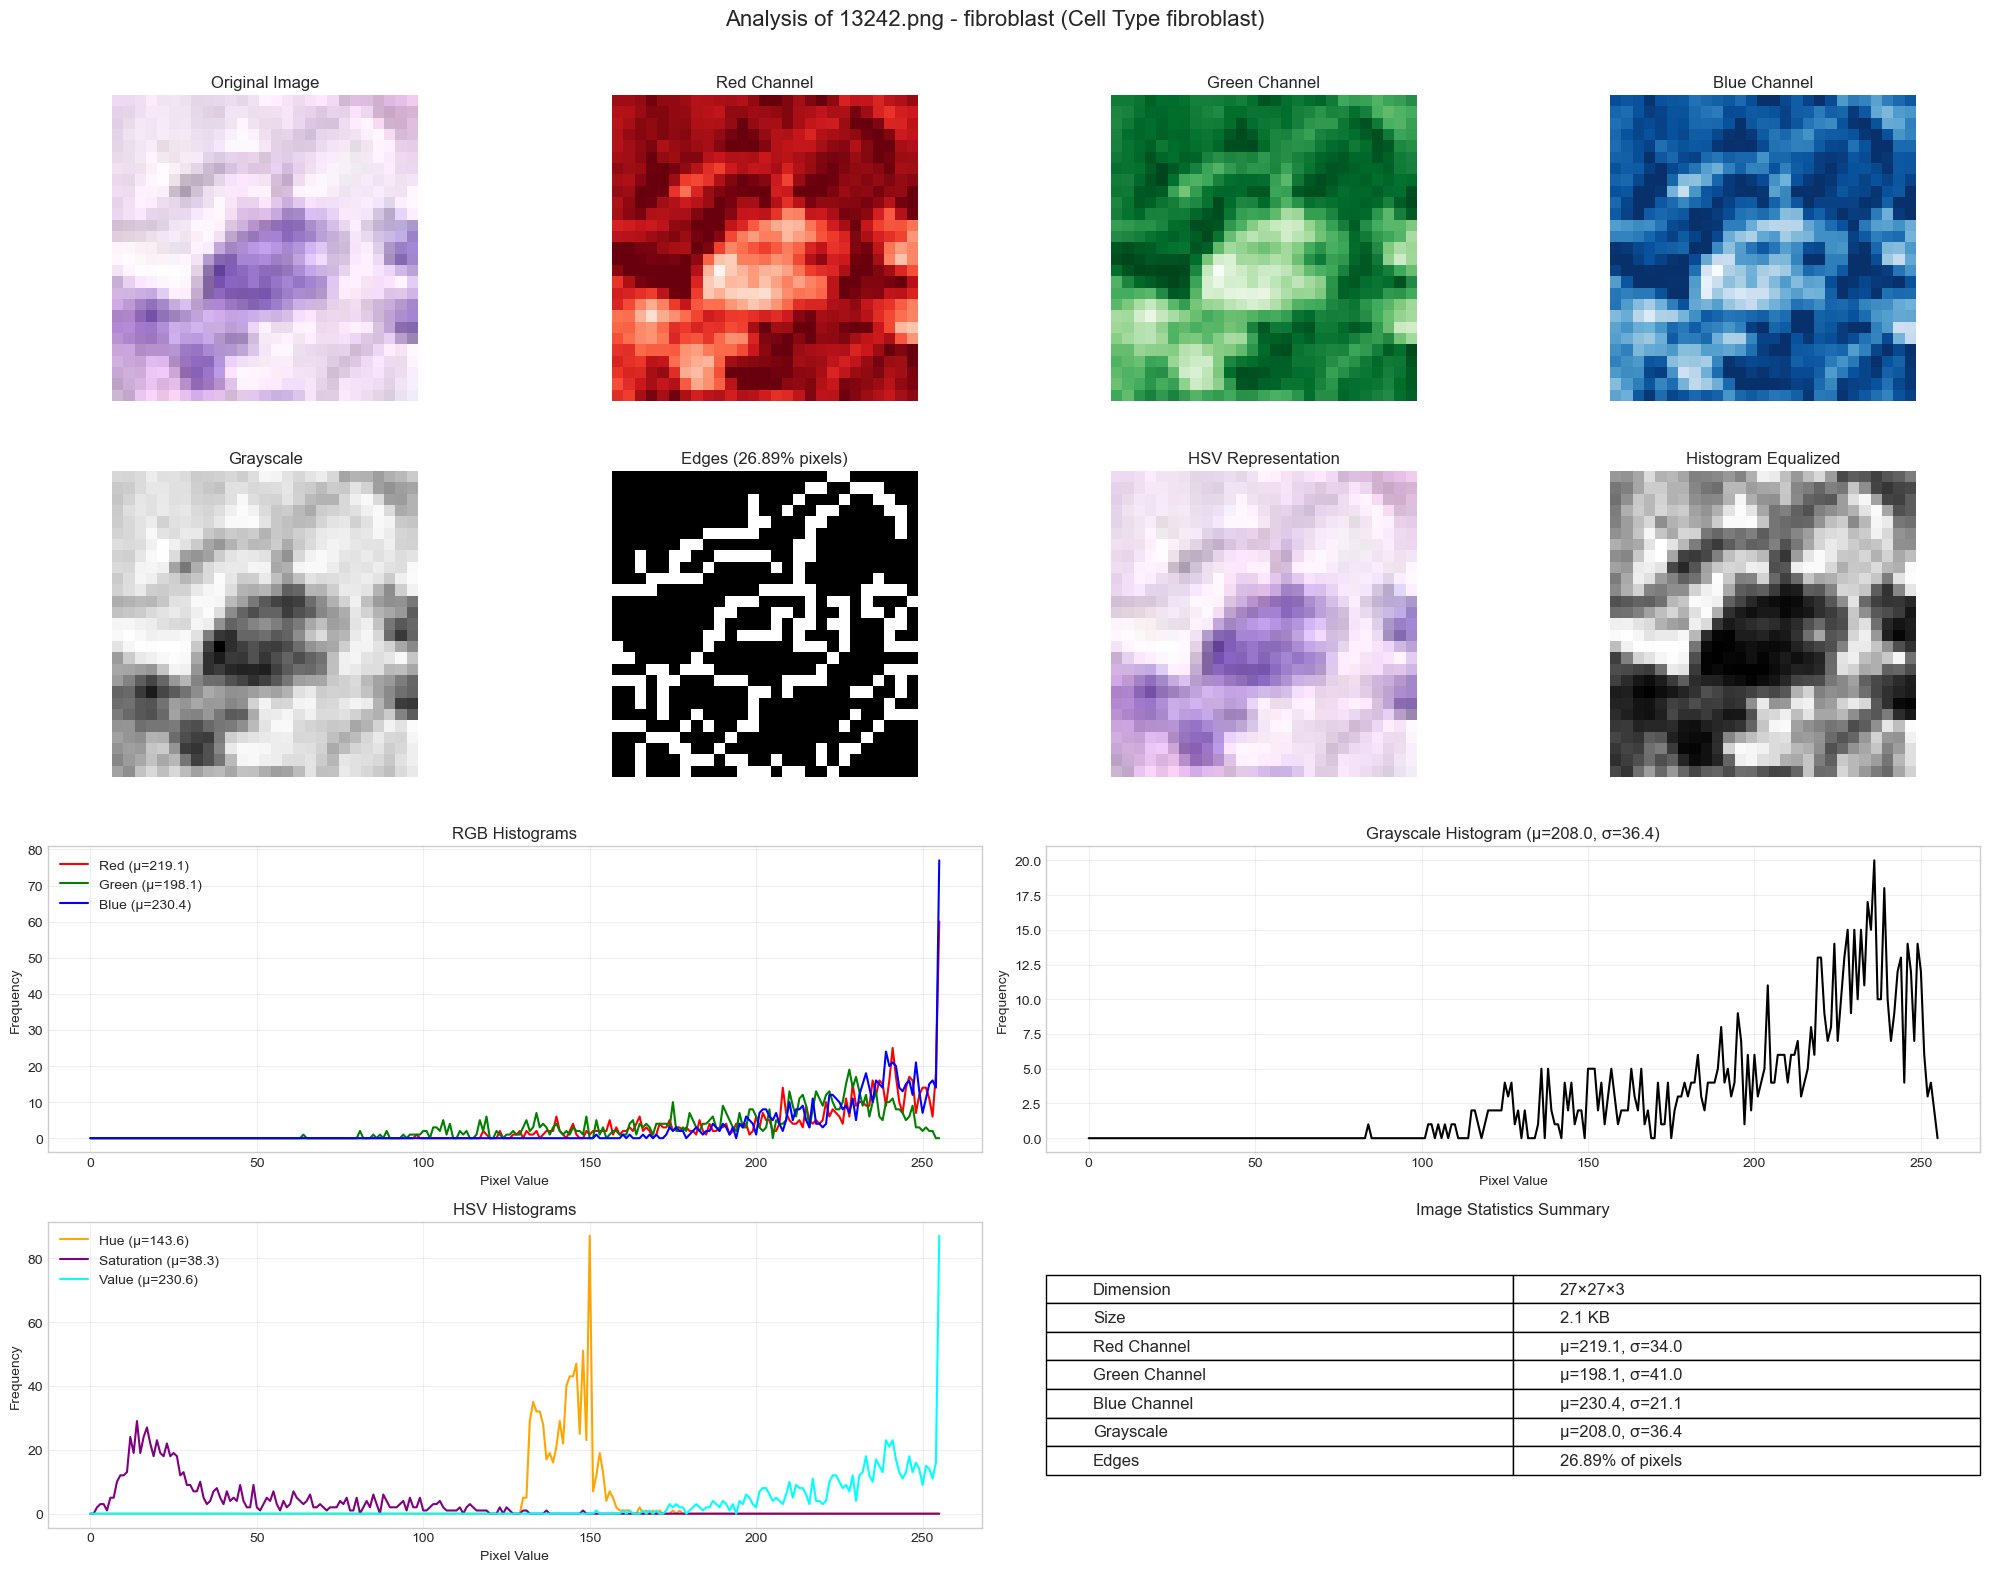

In [30]:
image_dir = "./data/patch_images"
analyze_images_by_cell_type(data, image_dir, 'fibroblast')

In [31]:
# TODO: Add the analysis here

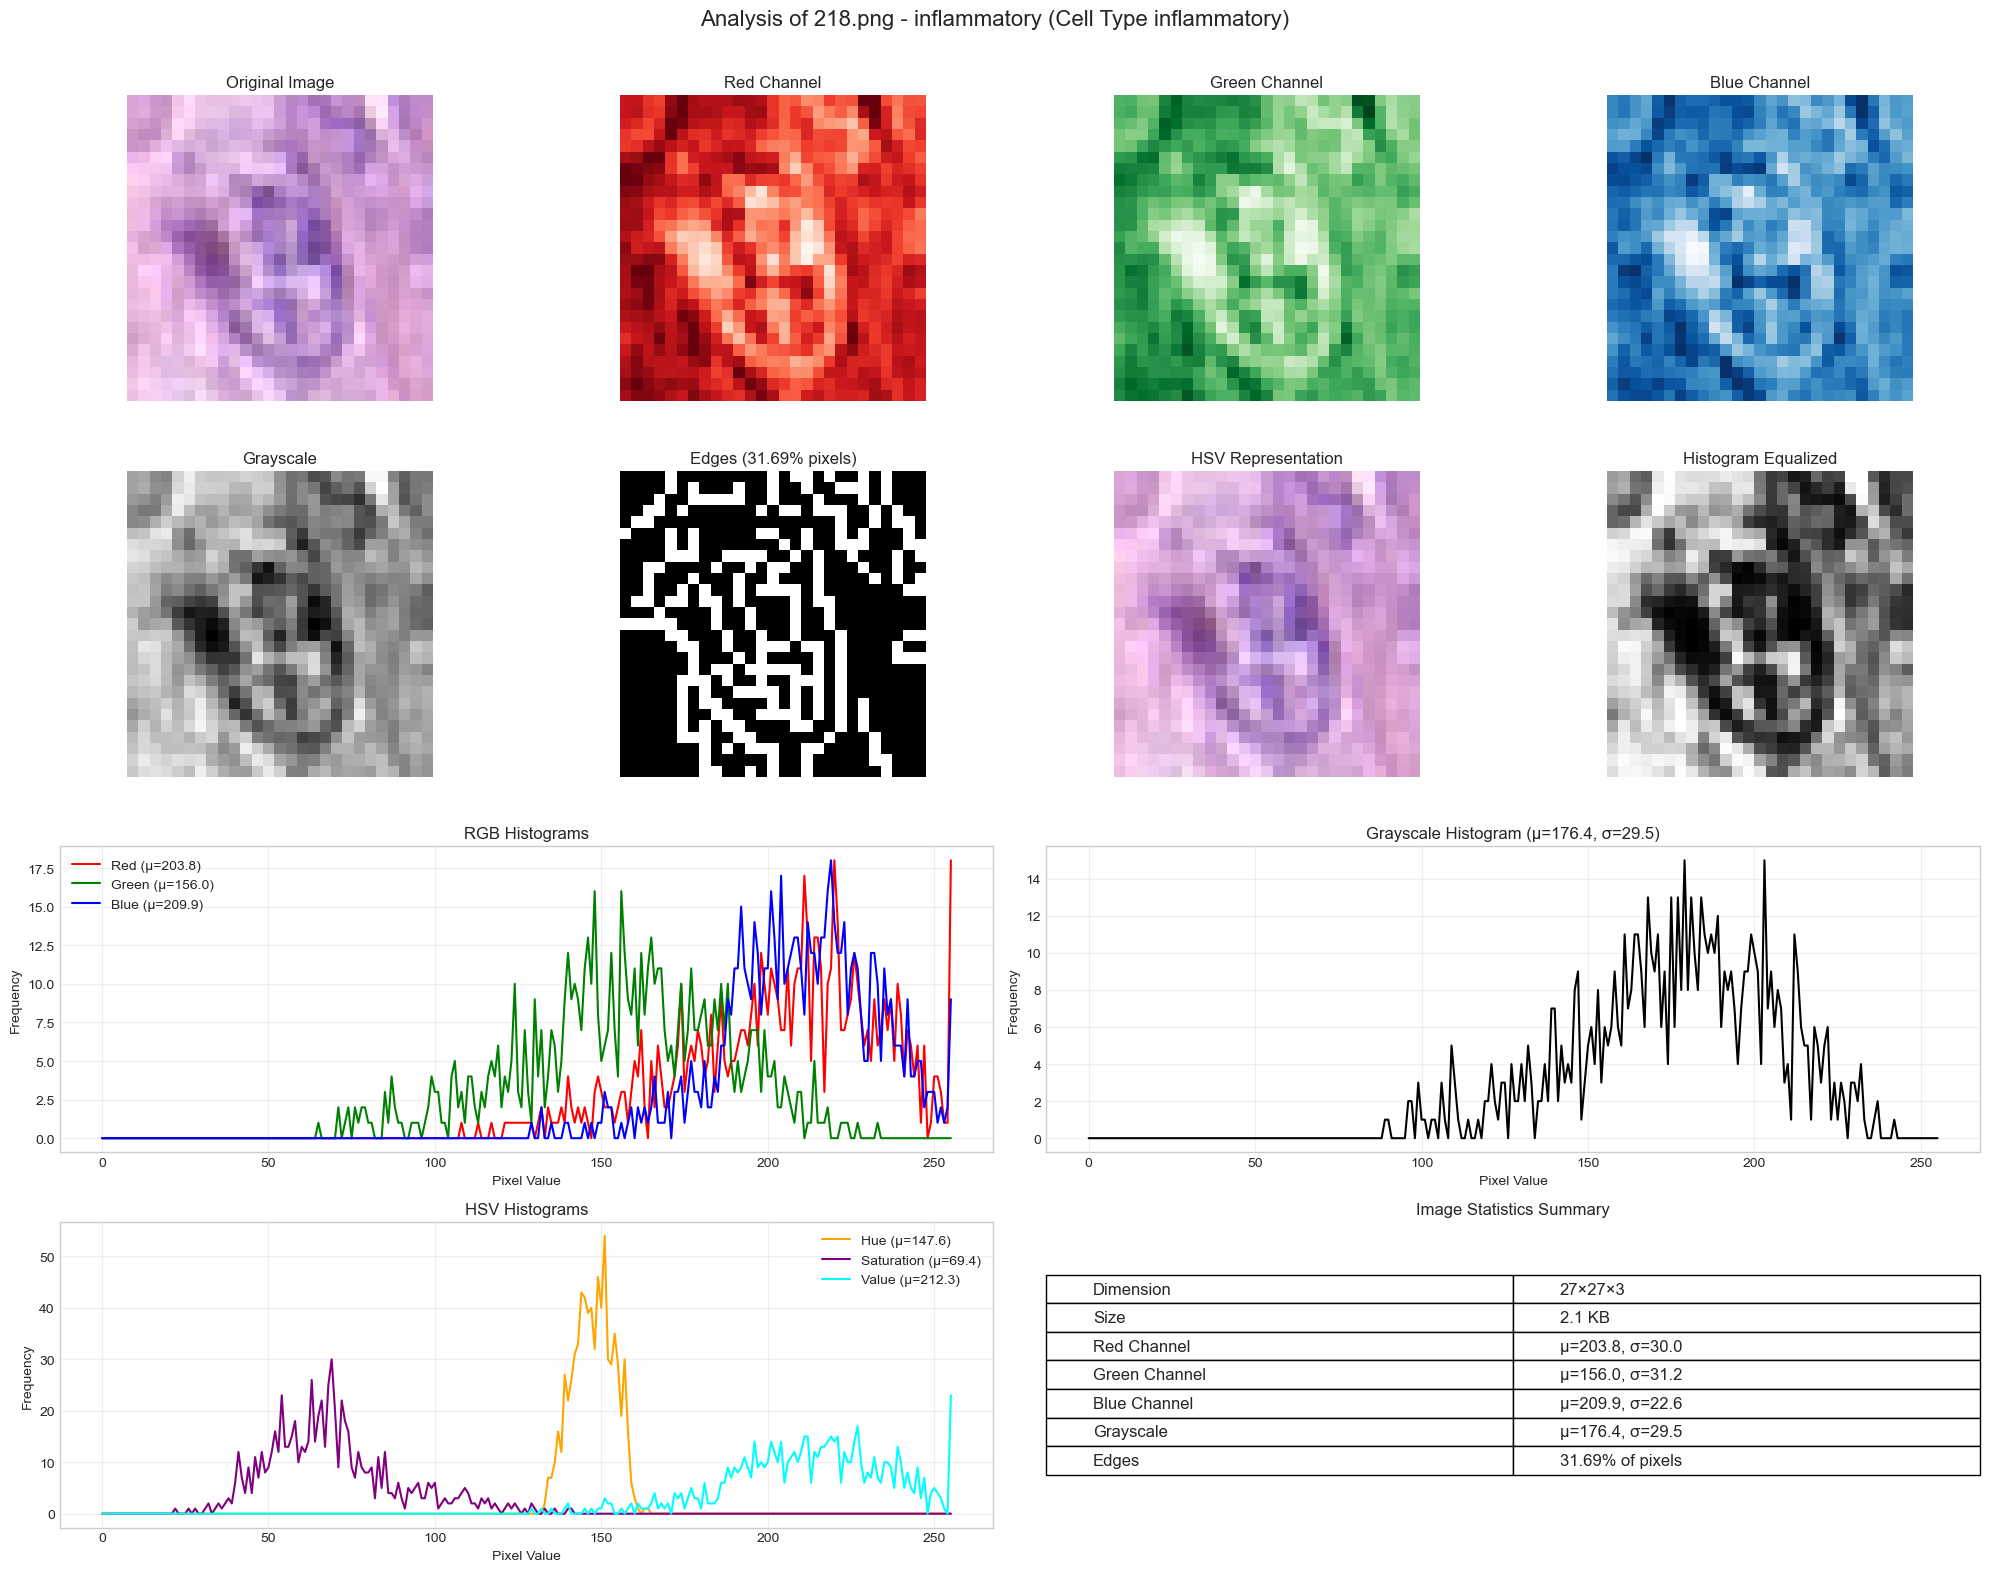

In [32]:
analyze_images_by_cell_type(data, image_dir, 'inflammatory')

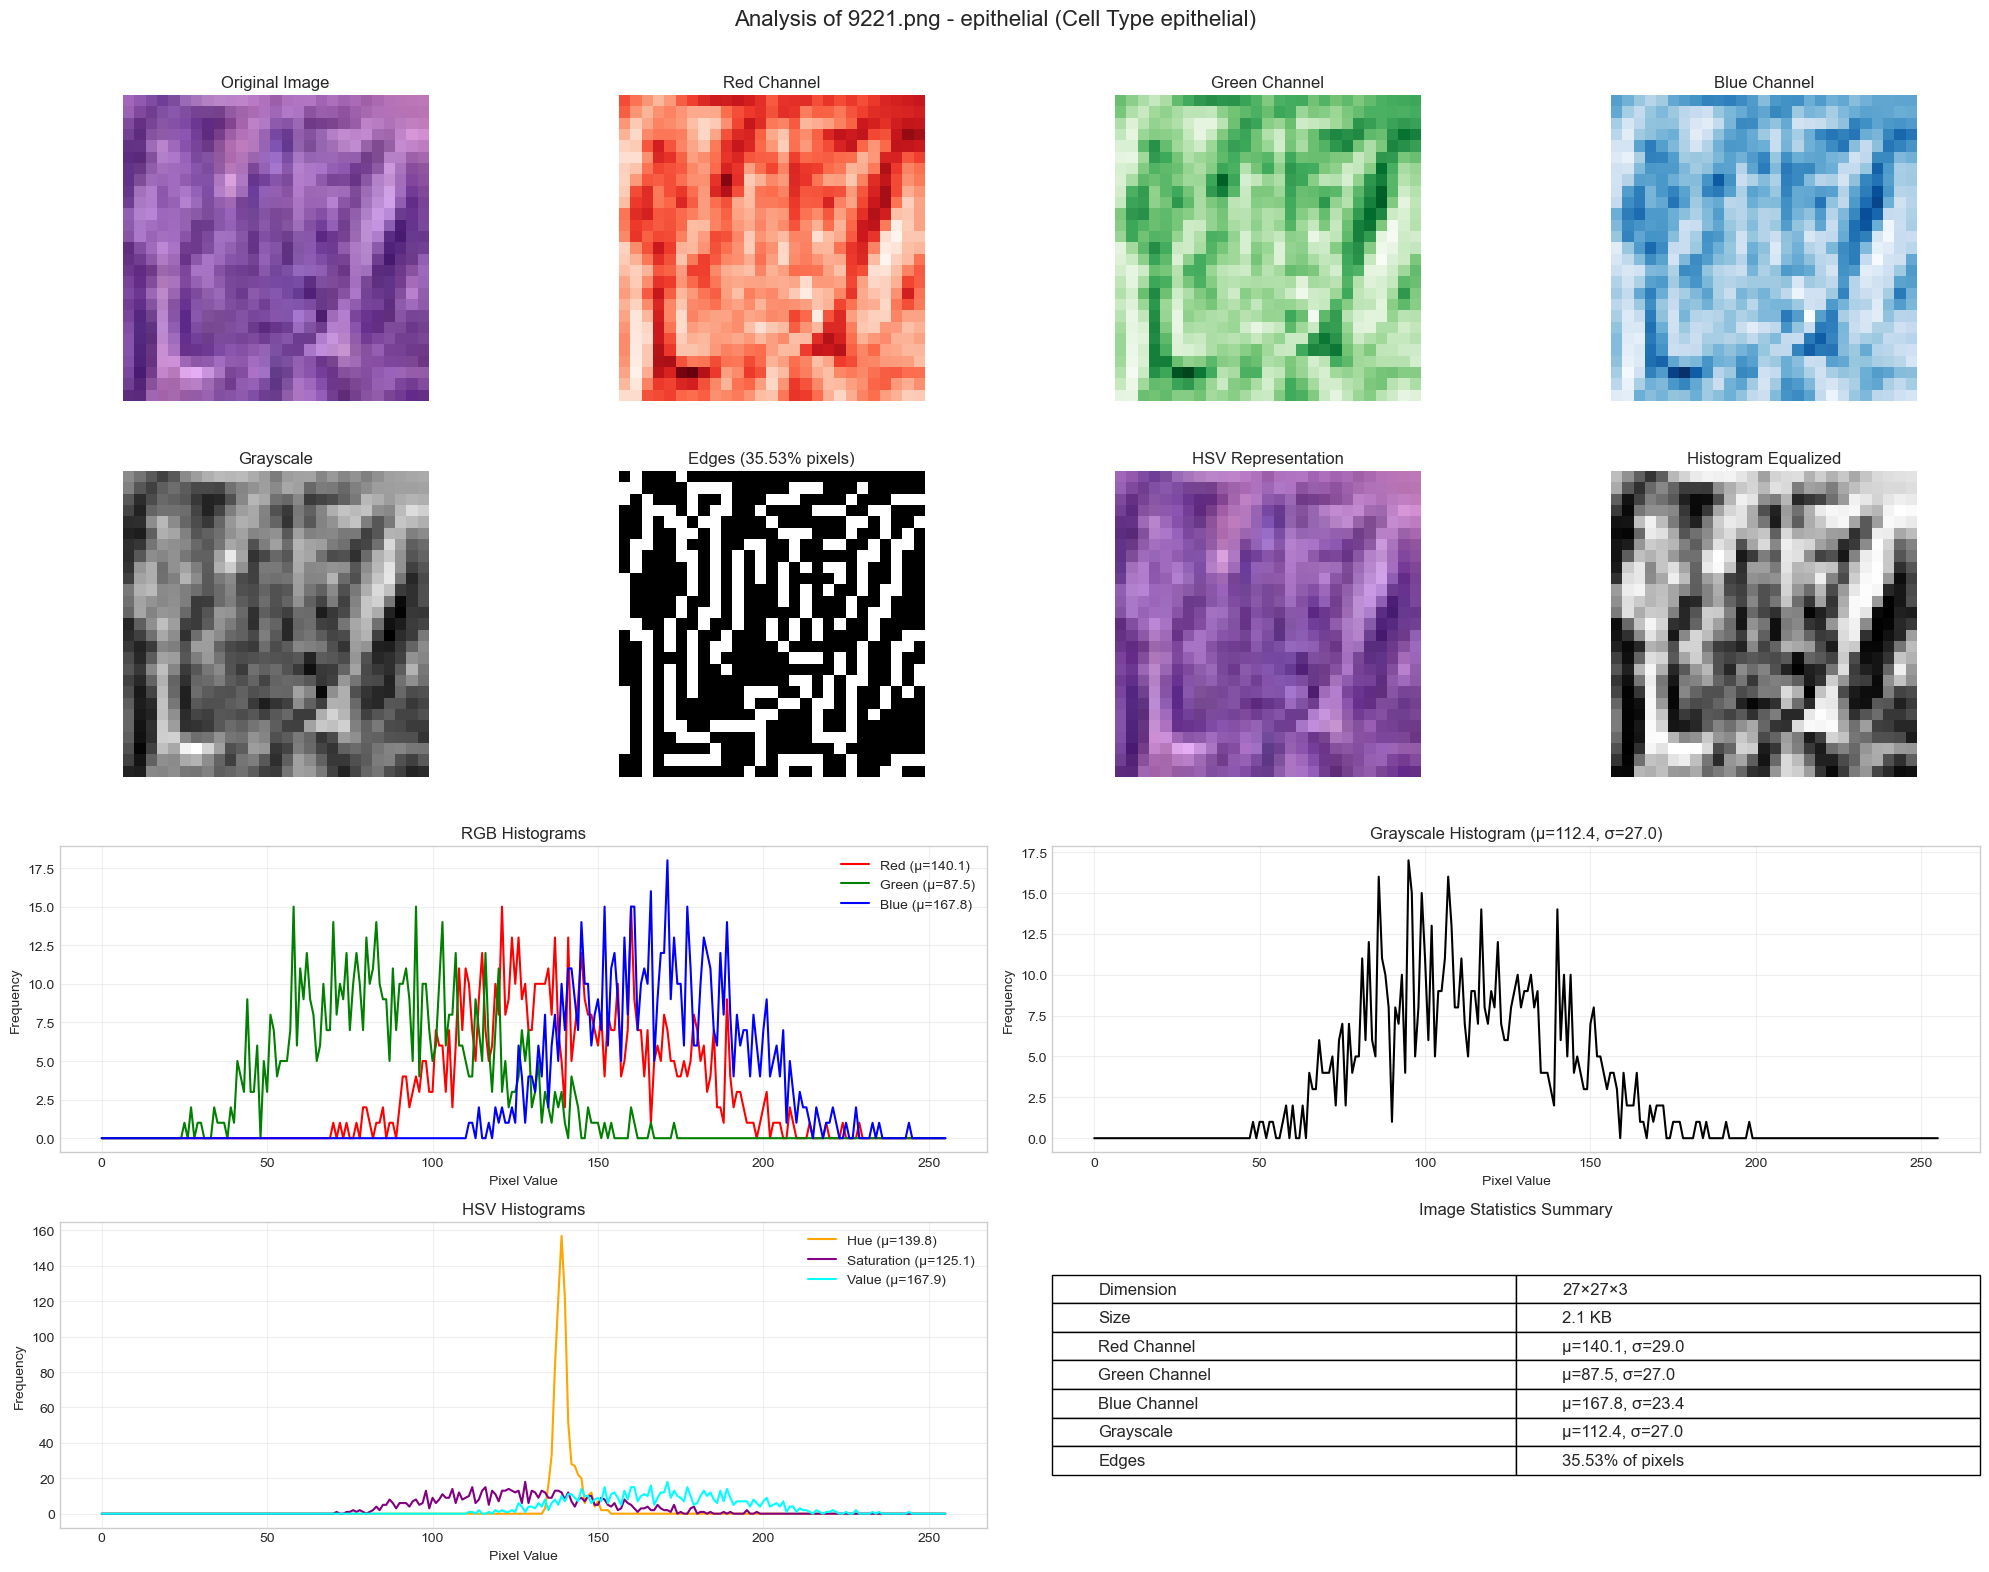

In [33]:
analyze_images_by_cell_type(data, image_dir, 'epithelial')

In [38]:
# !pip install pytesseract

In [40]:
import cv2
import pytesseract
import pandas as pd

def check_text_in_image(image_path, conf_threshold=60):
    try:
        image_path = './data/patch_images'
        image = cv2.imread(image_path)
        if image is None:
            return False  # image could not be read

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        custom_config = r'--oem 3 --psm 6'
        data = pytesseract.image_to_data(thresh, config=custom_config, output_type=pytesseract.Output.DICT)

        for i in range(len(data['text'])):
            if int(data['conf'][i]) > conf_threshold and data['text'][i].strip():
                return True
        return False
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return False

# Apply function to DataFrame
data['has_text'] = data['ImageName'].apply(check_text_in_image)

In [41]:
data['has_text'].value_counts()

has_text
False    7768
Name: count, dtype: int64

From the given dataset, there is no image has the embedded text

### EDA Summary

In summary, the given dataset has **9896** and **6** columns, in which two ID columns and the 3 categorical variables, which cellTypeName and cellType columns describe the cell type and isCancerous column tell if the patient has the cancer or not. Also, there is no additional features (i.e. text, integer), which indicate that for this task, both cellType and isCanerous will be predicted via the given images in patches_images folder. 
Besides that, the given dataset provides noticable information including:

- The cancer cell type has been encoded with numeric value
- The data is **imbalanced** data

As the data is imbalanced, data augumentation will be used. Since the cell type is, it is feasible to rotate or flipping the images without affecting the orientation.

## Data preprocessing

Based on the EDA result, two main data preprocessing will be considered. However, as this will be part of the training pipeline in later stage, a snippet code will be presented and show the example result for some sample images.
- **Image Normalization**: Since the pixel is has the value from 0-255, to avoid the scenario of having domninant terms affect the calculation, running normamlize to 0-1 is used. REF: https://www.tensorflow.org/tutorials/images/classification (Section using ReScaling)
- **Handle imbalanced dataset**: Since the class distribution is imbalanced, the Oversampling method will be used. The method aim to create more samples for the minority class so that it will have equal samples. However, duplicate images will cause the model being bias to the certain image or features, therefore, during the oversampling, image augumentation is used to generate different synthetic images. For the techniques, we applied the same augument method that mention in the paper (**REF**). 

In [50]:
from tensorflow.keras.layers import Rescaling
import tensorflow as tf

def preprocess_image(image_path, image_size=(27, 27)):
    normalization_layer = Rescaling(1./255)

    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    image = normalization_layer(image)  # Apply Keras rescaling
    return image


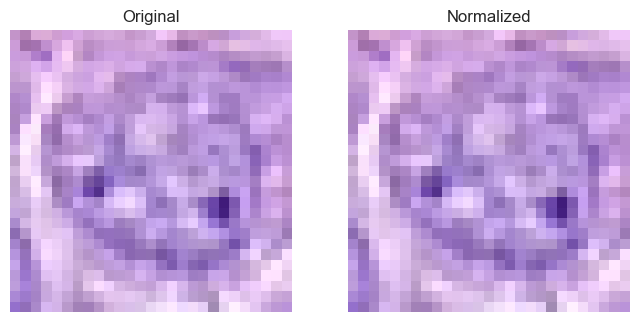

In [54]:
random_row = data.sample(1).iloc[0]
image_path = './data/patch_images/' + random_row['ImageName']

original_img = cv2.imread(image_path)
norm_img_tf = preprocess_image(image_path)

# Convert to numpy and scale back to uint8
image_np = norm_img_tf.numpy()
image_uint8 = (image_np * 255).astype(np.uint8)

# Convert RGB (TensorFlow) to BGR (OpenCV)
norm_img = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Normalized")
plt.imshow(cv2.cvtColor(norm_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

For the data augmentation, the current tensorflow does not have the flexibility to perform multiple augumentation, so we have created new class to handle these.

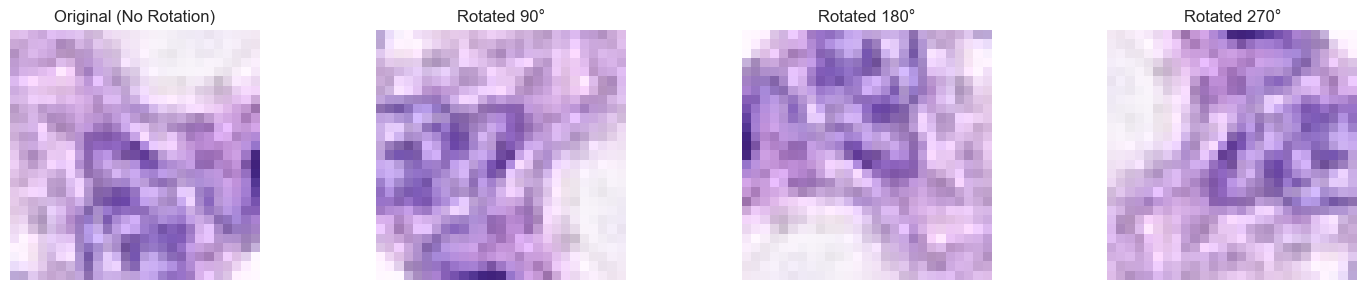

In [65]:
import matplotlib.pyplot as plt
import cv2

random_row = data.sample(1).iloc[0]
image_path = './data/patch_images/' + random_row['ImageName']
original_img = cv2.imread(image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Ensure proper color for plt

def rotate_image(img, angle):
    if angle == 90:
        return "Rotated 90°", cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 180:
        return "Rotated 180°", cv2.rotate(img, cv2.ROTATE_180)
    elif angle == 270:
        return "Rotated 270°", cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        return "Original (No Rotation)", img.copy()

rotated_img = [rotate_image(original_img, 0)]  # Include original
for angle in [90, 180, 270]:
    rotated_img.append(rotate_image(original_img, angle))

plt.figure(figsize=(15, 3))
for i, (title, img) in enumerate(rotated_img):
    plt.subplot(1, len(rotated_img), i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


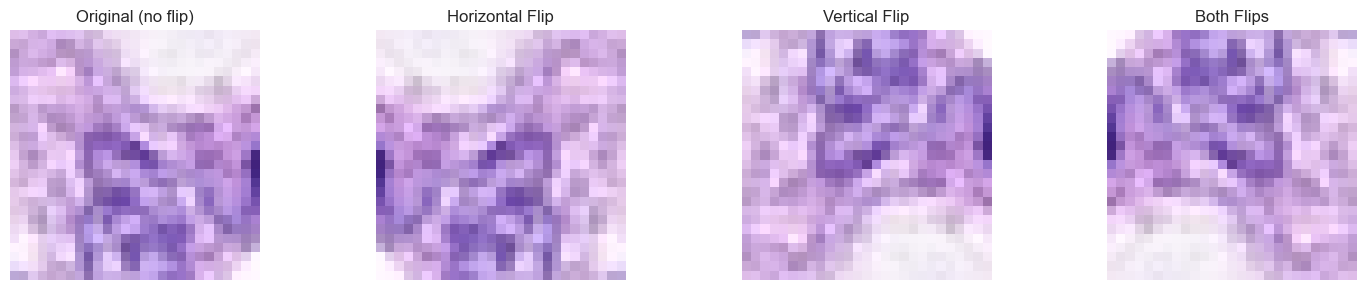

In [66]:
def flip_image(img, flip_code):
    flip_code = random.choice([-1, 0, 1])
    flipped = cv2.flip(img, flip_code)
    direction = {1: "Horizontal Flip", 0: "Vertical Flip", -1: "Both Flips"}[flip_code]
    return direction, flipped

flipped_imgs = [('Original (no flip)', original_img)]  # Include original
for angle in [-1, 0, 1]:
    flipped_imgs.append(flip_image(original_img, angle))

plt.figure(figsize=(15, 3))
for i, (title, img) in enumerate(flipped_imgs):
    plt.subplot(1, len(flipped_imgs), i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


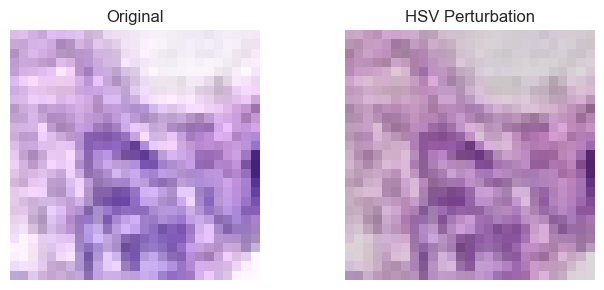

In [73]:
def hsv_perturbation(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
    h_factor = random.uniform(0.8, 1.2)
    s_factor = random.uniform(0.8, 1.2)
    v_factor = random.uniform(0.8, 1.2)
    hsv_img[:, :, 0] = np.clip(hsv_img[:, :, 0] * h_factor, 0, 179)
    hsv_img[:, :, 1] = np.clip(hsv_img[:, :, 1] * s_factor, 0, 255)
    hsv_img[:, :, 2] = np.clip(hsv_img[:, :, 2] * v_factor, 0, 255)
    return "HSV Perturbation", cv2.cvtColor(hsv_img.astype(np.uint8), cv2.COLOR_HSV2RGB)

hsv_perturbation_imgs = [('Original', original_img)]  # Include original
hsv_perturbation_imgs.append(hsv_perturbation(original_img))

plt.figure(figsize=(7, 3))
for i, (title, img) in enumerate(hsv_perturbation_imgs):
    plt.subplot(1, len(hsv_perturbation_imgs), i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

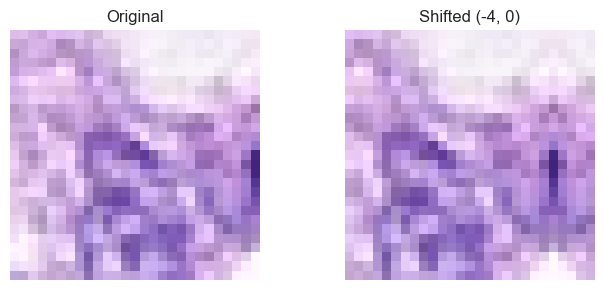

In [74]:
def location_shift(img):
    h, w = img.shape[:2]
    max_shift_h = h // 5
    max_shift_w = w // 5
    shift_h = random.randint(-max_shift_h, max_shift_h)
    shift_w = random.randint(-max_shift_w, max_shift_w)
    M = np.float32([[1, 0, shift_w], [0, 1, shift_h]])
    shifted = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    return f"Shifted ({shift_w}, {shift_h})", shifted

location_shifted_imgs = [('Original', original_img)]  # Include original
location_shifted_imgs.append(location_shift(original_img))

plt.figure(figsize=(7, 3))
for i, (title, img) in enumerate(location_shifted_imgs):
    plt.subplot(1, len(location_shifted_imgs), i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()